## An Analysis of socio-economic factors on national graduation rate

This project uses the EDFacts data consisting of district level statistics on graduation rates and performance on math & reading/language art assessments by race/ethnicity, gender, disability, English proficiency and socioeconomic status for two years 2011 and 2014. The objective of the project is

1) Determine if correlations between these variables (race, poverty, disabilities etc.) and cohort graduation rates exist. Does any state has less cohort graduation rate compare to another state? What variables most influence the cohort graduation rate per state?

2) Determine if there is a statistically significant difference between Northeast, Midwest, South and West region in cohort graduation rate per district. Perform k-means clustering to discover if cohort data can accurately predict a region.

3) Create regression model using machine learning to predict cohort graduation rate per district given EDFacts data for a particular district. This model could be used to granularize the district into schools and provide more localized estimates of cohort graduation rate.

In [1]:
%pylab inline

import re
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style(style='white')

Populating the interactive namespace from numpy and matplotlib


In [2]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [3]:
def cleandata(x):
    if (isinstance(x, str)):
        if re.search("[P][S]", x) and len(x) == 2:
            y = np.random.randint(0,100)

            return y
        if re.search("[L][T][0-9][0-9]", x) and len(x) == 4:
            z = pd.to_numeric(re.sub('[LT]', '', x))
            y = np.random.randint(0,z)
            return y
        
        if re.search("[L][E][0-9][0-9]", x) and len(x) == 4:
            z = pd.to_numeric(re.sub('[LE]', '', x))
            y = np.random.randint(0,z)
            return y
        
        if re.search("[L][E][0-9]", x) and len(x) == 3:
            z = pd.to_numeric(re.sub('[LE]', '', x))
            y = np.random.randint(0,z)
            return y
        
        if re.search("[G][E][0-9][0-9]", x) and len(x) == 4:
            z = pd.to_numeric(re.sub('[GE]', '', x))
            y = np.random.randint(z,100)

            return y
        
        if re.search("[G][T][0-9][0-9]", x) and len(x) == 4:
            z = pd.to_numeric(re.sub('[GT]', '', x))
            y = np.random.randint(z,100)

            return y
        
        if re.search("[0-9][0-9]-[0-9][0-9]", x) and len(x) == 5:
            z = x.split('-')
            a = pd.to_numeric(z[0])
            b = pd.to_numeric(z[1])
            y = np.random.randint(a,b)
            
            return y
        
        if re.search("[0-9]-[0-9]", x) and len(x) == 3:
            z = x.split('-')
            a = pd.to_numeric(z[0])
            b = pd.to_numeric(z[1])
            y = np.random.randint(a,b)
            
            return y
    return x

In [4]:
#Get State Code From State Code
def getStateCode(statecode):
    data = pd.read_csv('data/state.txt')
    dfstate = data.loc[data['CODE'] == statecode]
    
    return dfstate.ST.values

In [5]:
#Get FIPS Code From State Name
def getStateName(statecode):
    data = pd.read_csv('data/state.txt')
    dfstate = data.loc[data['CODE'] == statecode]
    
    return dfstate.STATENAME.values

In [6]:
def classifycohortrate(dl):
    if dl > 90: return 9
    elif 90 < dl <= 80: return 8
    elif 80 < dl <= 70: return 7
    elif 70 < dl <= 60: return 6
    elif 60 < dl <= 50: return 5
    elif 50 < dl <= 40: return 4
    elif 40 < dl <= 30: return 3
    elif 30 < dl <= 20: return 2
    else: return 1

In [7]:
acgrr13 = pd.read_csv("data/EDFacts/regulatory-adjusted-cohort-graduation-rate/2013/acgr-sch-sy2013-14.csv", dtype={"LEAID": str})

#Rename existing coulmns
acgrr13.columns = ['STATE','FIPCD','LEAID','LEANM','NCESSCH','SCHNAM','ALLA','ALLR', 
                'MAMA','MAMR','MASA','MASR','MBLA','MBLR','MHIA','MHIR','MTRA','MTRR', 
                'MWHA','MWHR','CWDA','CWDR','ECDA','ECDR','LEPA','LEPR','DATE_CUR','DATE_CUR'
               ]

acgrr13 = acgrr13.applymap(cleandata)
acgrr13 = acgrr13.fillna(0)
acgrr13 = acgrr13.replace(".",0)

for c in acgrr13.iloc[:, 7:26].columns:
    acgrr13[c] = pd.to_numeric(acgrr13[c]).astype(int)

acgrr13['YEAR'] = 2013

#Calculate the no of students graduated from different race
acgrr13['MAMG'] = round(acgrr13['MAMA']*acgrr13['MAMR']/100, 0).astype(int)
acgrr13['MASG'] = round(acgrr13['MASA']*acgrr13['MASR']/100, 0).astype(int)
acgrr13['MBLG'] = round(acgrr13['MBLA']*acgrr13['MBLR']/100, 0).astype(int)
acgrr13['MHIG'] = round(acgrr13['MHIA']*acgrr13['MHIR']/100, 0).astype(int)
acgrr13['MTRG'] = round(acgrr13['MTRA']*acgrr13['MTRR']/100, 0).astype(int)
acgrr13['MWHG'] = round(acgrr13['MWHA']*acgrr13['MWHR']/100, 0).astype(int)
acgrr13['CWDG'] = round(acgrr13['CWDA']*acgrr13['CWDR']/100, 0).astype(int)
acgrr13['ECDG'] = round(acgrr13['ECDA']*acgrr13['ECDR']/100, 0).astype(int)
acgrr13['LEPG'] = round(acgrr13['LEPA']*acgrr13['LEPR']/100, 0).astype(int)
acgrr13['ALLG'] = acgrr13['MAMG'] + acgrr13['MASG'] + acgrr13['MBLG'] + acgrr13['MHIG'] + acgrr13['MWHG']
acgrr13['ALLA'] = pd.to_numeric(acgrr13['ALLA']).astype(int)

acgrr13['ALLP'] = round(acgrr13['ALLG']*100/acgrr13['ALLA'],0)

acgrr13['MASP'] = round(acgrr13['MASG']*100/acgrr13['MASA'],0)
acgrr13['MWHP'] = round(acgrr13['MWHG']*100/acgrr13['MWHA'],0)
acgrr13['MBLP'] = round(acgrr13['MBLG']*100/acgrr13['MBLA'],0)
acgrr13['MHIP'] = round(acgrr13['MHIG']*100/acgrr13['MHIA'],0)
acgrr13['MAMP'] = round(acgrr13['MAMG']*100/acgrr13['MAMA'],0)
acgrr13['MTRP'] = round(acgrr13['MTRG']*100/acgrr13['MTRA'],0)
acgrr13['CWDP'] = round(acgrr13['CWDG']*100/acgrr13['CWDA'],0)
acgrr13['ECDP'] = round(acgrr13['ECDG']*100/acgrr13['ECDA'],0)
acgrr13['LEPP'] = round(acgrr13['LEPG']*100/acgrr13['LEPA'],0)

acgrr13 = acgrr13.fillna(0)

acgrr13['ALLP'] = acgrr13['ALLP'].astype(int)
acgrr13['MASP'] = acgrr13['MASP'].astype(int)
acgrr13['MWHP'] = acgrr13['MWHP'].astype(int)
acgrr13['MBLP'] = acgrr13['MBLP'].astype(int)
acgrr13['MHIP'] = acgrr13['MHIP'].astype(int)
acgrr13['MAMP'] = acgrr13['MAMP'].astype(int)
acgrr13['MTRP'] = acgrr13['MTRP'].astype(int)
acgrr13['CWDP'] = acgrr13['CWDP'].astype(int)
acgrr13['ECDP'] = acgrr13['ECDP'].astype(int)
acgrr13['LEPP'] = acgrr13['LEPP'].astype(int)

acgrr13['MASR'] = round(acgrr13['MASA']*100/acgrr13['ALLA'],0)
acgrr13['MWHR'] = round(acgrr13['MWHA']*100/acgrr13['ALLA'],0)
acgrr13['MBLR'] = round(acgrr13['MBLA']*100/acgrr13['ALLA'],0)
acgrr13['MHIR'] = round(acgrr13['MHIA']*100/acgrr13['ALLA'],0)
acgrr13['MAMR'] = round(acgrr13['MAMA']*100/acgrr13['ALLA'],0)
acgrr13['MTRR'] = round(acgrr13['MTRA']*100/acgrr13['ALLA'],0)
acgrr13['CWDR'] = round(acgrr13['CWDA']*100/acgrr13['ALLA'],0)
acgrr13['ECDR'] = round(acgrr13['ECDA']*100/acgrr13['ALLA'],0)
acgrr13['LEPR'] = round(acgrr13['LEPA']*100/acgrr13['ALLA'],0)

acgrr13 = acgrr13.fillna(0)

acgrr13['MASR'] = acgrr13['MASR'].astype(int)
acgrr13['MWHR'] = acgrr13['MWHR'].astype(int)
acgrr13['MBLR'] = acgrr13['MBLR'].astype(int)
acgrr13['MHIR'] = acgrr13['MHIR'].astype(int)
acgrr13['MAMR'] = acgrr13['MAMR'].astype(int)
acgrr13['MTRR'] = acgrr13['MTRR'].astype(int)
acgrr13['CWDR'] = acgrr13['CWDR'].astype(int)
acgrr13['ECDR'] = acgrr13['ECDR'].astype(int)
acgrr13['LEPR'] = acgrr13['LEPR'].astype(int)

acgr13 = acgrr13[['YEAR','STATE','FIPCD','LEAID','LEANM','NCESSCH','SCHNAM',
                        'ALLA','ALLG','ALLP','MAMA','MAMG','MAMP','MAMR', 
                        'MASA','MASG','MASP','MASR','MBLA','MBLG','MBLP','MBLR',
                        'MHIA','MHIG','MHIP','MHIR','MTRA','MTRG','MTRP','MTRR',
                        'MWHA','MWHG','MWHP','MWHR','CWDA','CWDG','CWDP','CWDR',
                        'ECDA','ECDG','ECDP','ECDR','LEPA','LEPG','LEPP','LEPR']]

In [8]:
acgrr14 = pd.read_csv("data/EDFacts/regulatory-adjusted-cohort-graduation-rate/2014/acgr-sch-sy2014-15.csv", dtype={"LEAID": str})

#Rename existing coulmns
acgrr14.columns = ['STATE','FIPCD','LEAID','LEANM','NCESSCH','SCHNAM','ALLA','ALLR', 
                'MAMA','MAMR','MASA','MASR','MBLA','MBLR','MHIA','MHIR','MTRA','MTRR', 
                'MWHA','MWHR','CWDA','CWDR','ECDA','ECDR','LEPA','LEPR','DATE_CUR']

acgrr14 = acgrr14.applymap(cleandata)
acgrr14 = acgrr14.fillna(0)
acgrr14 = acgrr14.replace(".",0)

for c in acgrr14.iloc[:, 7:26].columns:
    acgrr14[c] = pd.to_numeric(acgrr14[c]).astype(int)

acgrr14['YEAR'] = 2014

#Calculate the no of students graduated from different race
acgrr14['MAMG'] = round(acgrr14['MAMA']*acgrr14['MAMR']/100, 0).astype(int)
acgrr14['MASG'] = round(acgrr14['MASA']*acgrr14['MASR']/100, 0).astype(int)
acgrr14['MBLG'] = round(acgrr14['MBLA']*acgrr14['MBLR']/100, 0).astype(int)
acgrr14['MHIG'] = round(acgrr14['MHIA']*acgrr14['MHIR']/100, 0).astype(int)
acgrr14['MTRG'] = round(acgrr14['MTRA']*acgrr14['MTRR']/100, 0).astype(int)
acgrr14['MWHG'] = round(acgrr14['MWHA']*acgrr14['MWHR']/100, 0).astype(int)
acgrr14['CWDG'] = round(acgrr14['CWDA']*acgrr14['CWDR']/100, 0).astype(int)
acgrr14['ECDG'] = round(acgrr14['ECDA']*acgrr14['ECDR']/100, 0).astype(int)
acgrr14['LEPG'] = round(acgrr14['LEPA']*acgrr14['LEPR']/100, 0).astype(int)
acgrr14['ALLG'] = acgrr14['MAMG'] + acgrr14['MASG'] + acgrr14['MBLG'] + acgrr14['MHIG'] + acgrr14['MWHG']
acgrr14['ALLA'] = pd.to_numeric(acgrr14['ALLA']).astype(int)

acgrr14['ALLP'] = round(acgrr14['ALLG']*100/acgrr14['ALLA'],0)

acgrr14['MASP'] = round(acgrr14['MASG']*100/acgrr14['MASA'],0)
acgrr14['MWHP'] = round(acgrr14['MWHG']*100/acgrr14['MWHA'],0)
acgrr14['MBLP'] = round(acgrr14['MBLG']*100/acgrr14['MBLA'],0)
acgrr14['MHIP'] = round(acgrr14['MHIG']*100/acgrr14['MHIA'],0)
acgrr14['MAMP'] = round(acgrr14['MAMG']*100/acgrr14['MAMA'],0)
acgrr14['MTRP'] = round(acgrr14['MTRG']*100/acgrr14['MTRA'],0)
acgrr14['CWDP'] = round(acgrr14['CWDG']*100/acgrr14['CWDA'],0)
acgrr14['ECDP'] = round(acgrr14['ECDG']*100/acgrr14['ECDA'],0)
acgrr14['LEPP'] = round(acgrr14['LEPG']*100/acgrr14['LEPA'],0)

acgrr14 = acgrr14.fillna(0)

acgrr14['ALLP'] = acgrr14['ALLP'].astype(int)
acgrr14['MASP'] = acgrr14['MASP'].astype(int)
acgrr14['MWHP'] = acgrr14['MWHP'].astype(int)
acgrr14['MBLP'] = acgrr14['MBLP'].astype(int)
acgrr14['MHIP'] = acgrr14['MHIP'].astype(int)
acgrr14['MAMP'] = acgrr14['MAMP'].astype(int)
acgrr14['MTRP'] = acgrr14['MTRP'].astype(int)
acgrr14['CWDP'] = acgrr14['CWDP'].astype(int)
acgrr14['ECDP'] = acgrr14['ECDP'].astype(int)
acgrr14['LEPP'] = acgrr14['LEPP'].astype(int)

acgrr14['MASR'] = round(acgrr14['MASA']*100/acgrr14['ALLA'],0)
acgrr14['MWHR'] = round(acgrr14['MWHA']*100/acgrr14['ALLA'],0)
acgrr14['MBLR'] = round(acgrr14['MBLA']*100/acgrr14['ALLA'],0)
acgrr14['MHIR'] = round(acgrr14['MHIA']*100/acgrr14['ALLA'],0)
acgrr14['MAMR'] = round(acgrr14['MAMA']*100/acgrr14['ALLA'],0)
acgrr14['MTRR'] = round(acgrr14['MTRA']*100/acgrr14['ALLA'],0)
acgrr14['CWDR'] = round(acgrr14['CWDA']*100/acgrr14['ALLA'],0)
acgrr14['ECDR'] = round(acgrr14['ECDA']*100/acgrr14['ALLA'],0)
acgrr14['LEPR'] = round(acgrr14['LEPA']*100/acgrr14['ALLA'],0)

acgrr14 = acgrr14.fillna(0)

acgrr14['MASR'] = acgrr14['MASR'].astype(int)
acgrr14['MWHR'] = acgrr14['MWHR'].astype(int)
acgrr14['MBLR'] = acgrr14['MBLR'].astype(int)
acgrr14['MHIR'] = acgrr14['MHIR'].astype(int)
acgrr14['MAMR'] = acgrr14['MAMR'].astype(int)
acgrr14['MTRR'] = acgrr14['MTRR'].astype(int)
acgrr14['CWDR'] = acgrr14['CWDR'].astype(int)
acgrr14['ECDR'] = acgrr14['ECDR'].astype(int)
acgrr14['LEPR'] = acgrr14['LEPR'].astype(int)

acgr14 = acgrr14[['YEAR','STATE','FIPCD','LEAID','LEANM','NCESSCH','SCHNAM',
                        'ALLA','ALLG','ALLP','MAMA','MAMG','MAMP','MAMR', 
                        'MASA','MASG','MASP','MASR','MBLA','MBLG','MBLP','MBLR',
                        'MHIA','MHIG','MHIP','MHIR','MTRA','MTRG','MTRP','MTRR',
                        'MWHA','MWHG','MWHP','MWHR','CWDA','CWDG','CWDP','CWDR',
                        'ECDA','ECDG','ECDP','ECDR','LEPA','LEPG','LEPP','LEPR']]

In [9]:
import codecs

doc = codecs.open("data/NCES/2013/sc132a.txt",encoding='utf-8',errors='replace')

ssusr13 = pd.read_csv(doc, sep='\t', dtype=str, na_values={'-1','-2'})
ssusr13['NCESSCH'] = ssusr13['NCESSCH'].astype(int)
ssusr13['FTE'] = pd.factorize(ssusr13['FTE'])[0]

#ssusr13.fillna(0)

ssus13 = ssusr13.copy()
ssus13 = ssus13[ssus13['LEVEL'] == '3']

ssus13 = ssus13[['NCESSCH','TYPE','AM12M','AM12F','AS12M','AS12F','HI12M','HI12F','BL12M','BL12F','WH12M',
                 'WH12F','HP12M','HP12F','TR12M','TR12F','G12','TOTFRL','FTE']]
for c in ssus13.iloc[:, 2:19].columns:
    ssus13[c] = pd.to_numeric(ssus13[c], errors='coerce')
    
ssus13['AMMR'] = round(ssus13['AM12M']*100/ssus13['G12'],2)
ssus13['AMFR'] = round(ssus13['AM12F']*100/ssus13['G12'],2)
ssus13['ASMR'] = round(ssus13['AS12M']*100/ssus13['G12'],2)
ssus13['ASFR'] = round(ssus13['AS12F']*100/ssus13['G12'],2)
ssus13['HIMR'] = round(ssus13['HI12M']*100/ssus13['G12'],2)
ssus13['HIFR'] = round(ssus13['HI12F']*100/ssus13['G12'],2)
ssus13['BLMR'] = round(ssus13['BL12M']*100/ssus13['G12'],2)
ssus13['BLFR'] = round(ssus13['BL12F']*100/ssus13['G12'],2)
ssus13['WHMR'] = round(ssus13['WH12M']*100/ssus13['G12'],2)
ssus13['WHFR'] = round(ssus13['WH12F']*100/ssus13['G12'],2)
ssus13['HPMR'] = round(ssus13['HP12M']*100/ssus13['G12'],2)
ssus13['HPFR'] = round(ssus13['HP12F']*100/ssus13['G12'],2)
ssus13['TRMR'] = round(ssus13['TR12M']*100/ssus13['G12'],2)
ssus13['TRFR'] = round(ssus13['TR12F']*100/ssus13['G12'],2)
ssus13 = ssus13.fillna(0)

acgr2013 = pd.merge(acgr13, ssus13, how='inner', on='NCESSCH')
#acgr2013 = acgr2013[acgr2013['LEVEL'] == '3']
#acgr2013 = acgr2013[acgr2013['G12OFFRD'] == '1']
#acgr2013 = acgr2013[acgr2013['ALLP'] != 0]

#acgr2013.iloc[100:105,1:16]
#acgr2013.iloc[100:105,16:32]
#acgr2013.iloc[100:105,32:48]
#acgr2013.iloc[100:105,48:64]
#acgr2013.iloc[100:105,64:80]

In [10]:
doc = codecs.open("data/NCES/2014/ccd_sch_029_1415_w_0216601a.txt",encoding='utf-8', errors='replace')
ssusr1 = pd.read_csv(doc, sep='\t', dtype=str)
ssus1 = ssusr1[['NCESSCH','SCH_TYPE','SY_STATUS','RECON_STATUS','G12OFFERED','LEVEL','CHARTER_TEXT','VIRTUAL']]
ssus1.columns = [['NCESSCH','TYPE','STATUS','RECONSTF','G12OFFRD','LEVEL','CHARTER','VIRTUALSTAT']]

doc = codecs.open("data/NCES/2014/ccd_sch_033_1415_w_0216161a.txt",encoding='utf-8', errors='replace')
ssusr2 = pd.read_csv(doc, sep='\t', dtype=str)
ssus2 = ssusr2[['NCESSCH','TOTFRL']]

doc = codecs.open("data/NCES/2014/ccd_sch_052_1415_w_0216161a.txt",encoding='utf-8', errors='replace')
ssusr3 = pd.read_csv(doc, sep='\t', dtype=str)
ssus3 = ssusr3[['NCESSCH','G12','AM12M','AM12F','AS12M','AS12F','HI12M','HI12F','BL12M','BL12F',
        'WH12M','WH12F','HP12M','HP12F','TR12M','TR12F']]

doc = codecs.open("data/NCES/2014/ccd_sch_059_1415_w_0216161a.txt",encoding='utf-8', errors='replace')
ssusr4 = pd.read_csv(doc, sep='\t', dtype=str)
ssus4 = ssusr4[['NCESSCH','FTE']]

doc = codecs.open("data/NCES/2014/ccd_sch_129_1415_w_0216161a.txt",encoding='utf-8', errors='replace')
ssusr5 = pd.read_csv(doc, sep='\t', dtype=str)
ssus5 = ssusr5[['NCESSCH','MAGNET_TEXT','SHARED_TIME']]
ssus5.columns = [['NCESSCH','MAGNET','SHARED']]

temp1 = pd.merge(ssus1, ssus2, how='inner', on='NCESSCH')
temp2 = pd.merge(temp1, ssus3, how='inner', on='NCESSCH')
temp3 = pd.merge(temp2, ssus4, how='inner', on='NCESSCH')

ssusr14 = pd.merge(temp3, ssus5, how='inner', on='NCESSCH')

ssusr14['NCESSCH'] = ssusr14['NCESSCH'].astype(int)
ssusr14['FTE'] = pd.factorize(ssusr14['FTE'])[0]

#ssus14.fillna(0)

ssus14 = ssusr14.copy()
ssus14 = ssus14[ssus14['LEVEL'] == '3']

ssus14 = ssus14[['NCESSCH','TYPE','AM12M','AM12F','AS12M','AS12F','HI12M','HI12F','BL12M','BL12F','WH12M',
                 'WH12F','HP12M','HP12F','TR12M','TR12F','G12','TOTFRL','FTE']]
for c in ssus14.iloc[:, 2:19].columns:
    ssus14[c] = pd.to_numeric(ssus14[c], errors='coerce')
    
ssus14['AMMR'] = round(ssus14['AM12M']*100/ssus14['G12'],2)
ssus14['AMFR'] = round(ssus14['AM12F']*100/ssus14['G12'],2)
ssus14['ASMR'] = round(ssus14['AS12M']*100/ssus14['G12'],2)
ssus14['ASFR'] = round(ssus14['AS12F']*100/ssus14['G12'],2)
ssus14['HIMR'] = round(ssus14['HI12M']*100/ssus14['G12'],2)
ssus14['HIFR'] = round(ssus14['HI12F']*100/ssus14['G12'],2)
ssus14['BLMR'] = round(ssus14['BL12M']*100/ssus14['G12'],2)
ssus14['BLFR'] = round(ssus14['BL12F']*100/ssus14['G12'],2)
ssus14['WHMR'] = round(ssus14['WH12M']*100/ssus14['G12'],2)
ssus14['WHFR'] = round(ssus14['WH12F']*100/ssus14['G12'],2)
ssus14['HPMR'] = round(ssus14['HP12M']*100/ssus14['G12'],2)
ssus14['HPFR'] = round(ssus14['HP12F']*100/ssus14['G12'],2)
ssus14['TRMR'] = round(ssus14['TR12M']*100/ssus14['G12'],2)
ssus14['TRFR'] = round(ssus14['TR12F']*100/ssus14['G12'],2)
ssus14 = ssus14.fillna(0)

acgr2014 = pd.merge(acgr14, ssus14, how='inner', on='NCESSCH')
#acgr2014 = acgr2014[acgr2014['LEVEL'] == '3']
#acgr2014 = acgr2014[acgr2014['G12OFFRD'] == 'Y']
#acgr2014 = acgr2014[acgr2014['ALLP'] != 0]

#acgr2014.iloc[100:105,1:16]
#acgr2014.iloc[100:105,16:32]
#acgr2014.iloc[100:105,32:48]
#acgr2014.iloc[100:105,48:64]
#acgr2014.iloc[100:105,64:78]

## Data Exploration

To begin, we'll examine relationships in the cohort graduation data set. Later in the analysis, we will pull in EDFacts data to understand each district's racial distribution, ELSI data, poverty data and assessment data, etc.
First, we'll look at two statements made by Department of Education when introducing this dataset:

1) In school year 2014–15, the adjusted cohort graduation rate (ACGR) for public high school students rose to 83 percent, the highest rate since the measure was first collected in 2010–11.

2) Asian/Pacific Islander students had the highest ACGR (90 percent), followed by White (88 percent), Hispanic (78 percent), Black (75 percent), and American Indian/Alaska Native (72 percent) students

* https://nces.ed.gov/programs/coe/indicator_coi.asp

#### First, let's test the statement made by Department of Education that "The adjusted cohort graduation rate (ACGR) for public high school students rose to 83%.

In [11]:
nationalacgr2013 = int(round(np.sum(acgr2013['ALLG'])*100/np.sum(acgr2013['ALLA']),0))
nationalacgr2014 = int(round(np.sum(acgr2014['ALLG'])*100/np.sum(acgr2014['ALLA']),0))

print(color.BOLD + '\nAfter verifying the clean regulatory adjusted cohort graduation rate for all district we \ncan see that in school year 2014-15 the graduation rate at the national level is %s%%, an \nincrease from %s%% in 2011-12. How does the graduation rate vary depending on the state? \nThis will be explored later in the analysis.' 
      %(nationalacgr2013, nationalacgr2014) + color.BOLD)


After verifying the clean regulatory adjusted cohort graduation rate for all district we 
can see that in school year 2014-15 the graduation rate at the national level is 82%, an 
increase from 83% in 2011-12. How does the graduation rate vary depending on the state? 
This will be explored later in the analysis.


#### Now check how the graduation rates are distributed at the school level for school year 2013-14 and 2014-15.

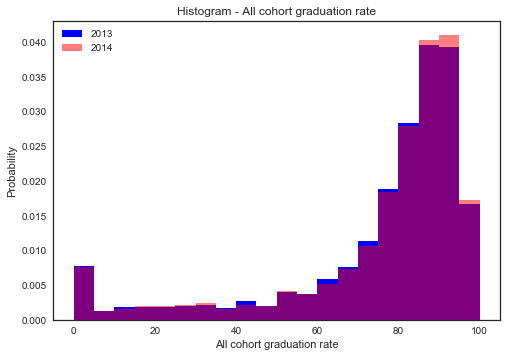


From the above histogram we can assume that the adjusted cohort graduation rate is skewed 
Normal distribution. Hence we can apply the pricipal of statistical hypothesis to conclude that graduation rate at the national level is 83%.

Hence we construct our Hypothesis as follows

NULL HYPOTHESIS: 

The national adjusted cohort graduation rate is 83%

ALTERNATE HYPOTHESIS: 

The national adjusted cohort graduation rate is not 83%


In [12]:
plt.hist(acgr2013['ALLP'], bins=20, histtype='bar', normed=True, color='b', label='2013')
plt.hist(acgr2014['ALLP'], bins=20, histtype='bar', normed=True, color='r', alpha=0.5, label='2014')
plt.title("Histogram - All cohort graduation rate")
plt.xlabel("All cohort graduation rate")
plt.ylabel("Probability")
plt.legend()
plt.show()

print(color.BOLD + '\nFrom the above histogram we can assume that the adjusted cohort graduation rate is skewed \nNormal distribution.', 
      'Hence we can apply the pricipal of statistical hypothesis to conclude that graduation rate at the national level is %s%%.' %(nationalacgr2014) + color.BOLD)

print(color.BOLD + '\nHence we construct our Hypothesis as follows' + color.BOLD)
print(color.BOLD + '\nNULL HYPOTHESIS:', color.BOLD)
print(color.BOLD + '\nThe national adjusted cohort graduation rate is %s%%' %(nationalacgr2014) + color.BOLD)
print(color.BOLD + '\nALTERNATE HYPOTHESIS:', color.BOLD)
print(color.BOLD + '\nThe national adjusted cohort graduation rate is not %s%%' %(nationalacgr2014) + color.BOLD)

In [31]:
from statsmodels.stats.weightstats import ztest

acgr2014r = acgr2014[acgr2014['ALLP'] !=0]
dftest = acgr2014r.take(np.random.permutation(len(acgr2014r))[:1000])

mn = round(dftest.ALLP.mean(),2)
sd = round(dftest.ALLP.std(),2)

zstat, pval = ztest(acgr2014r['ALLP'], x2=None, value=80, alternative='two-sided', usevar='pooled', ddof=1.0)

print(color.BOLD + '\nWe are having a random sample of 200 records with mean %s and standard deviation %s, \nn = 200 is large enough for the CLT to apply so the distribution of sample means is \napproximately normal.'%(mn, sd),
                    'The population SD is unknown, so a z-test is called with H0 = 83.0 \nand Ha <> 83.0' + color.BOLD)

print(color.BOLD + "\nThe test result shows the test z-statistic as %s and the and P-value as %s" %(round(zstat, 4), round(pval,4)), 
                    "With \nthis P-value, %s > 0.05, there is sufficient evidence that we cannot reject H0 and \nthere is sufficient evidence that that the national adjusted cohort graduation rate is %s%%."%(round(pval,4), nationalacgr2014) + color.BOLD)


We are having a random sample of 200 records with mean 78.22 and standard deviation 19.0, 
n = 200 is large enough for the CLT to apply so the distribution of sample means is 
approximately normal. The population SD is unknown, so a z-test is called with H0 = 83.0 
and Ha <> 83.0

The test result shows the test z-statistic as -11.4648 and the and P-value as 0.0 With 
this P-value, 0.0 > 0.05, there is sufficient evidence that we cannot reject H0 and 
there is sufficient evidence that that the national adjusted cohort graduation rate is 83%.


In [14]:
acgrMAM2014 = int(round(np.sum(acgr2014['MAMG'])*100/np.sum(acgr2014['MAMA']),0))
acgrMAS2014 = int(round(np.sum(acgr2014['MASG'])*100/np.sum(acgr2014['MASA']),0))
acgrMBL2014 = int(round(np.sum(acgr2014['MBLG'])*100/np.sum(acgr2014['MBLA']),0))
acgrMHI2014 = int(round(np.sum(acgr2014['MHIG'])*100/np.sum(acgr2014['MHIA']),0))
acgrMWH2014 = int(round(np.sum(acgr2014['MWHG'])*100/np.sum(acgr2014['MWHA']),0))

print(color.BOLD + 'Now, let\'s verify the other statement made by Department of Education that "In school year 2014-15, Asian/Pacific Islander students had the highest ACGR of 90%, followed by White 88%\n, Hispanic 78%, Black 75% and American Indian/Alaska Native 72% students.' + color.BOLD)

print(color.BOLD + '\nAfter calculating the cohort graduation rate for major racial and ethnic groups, we can see that in school year 2014–15 Asian/Pacific Islander students has the highest ACGR of %s%%, \nfollowed by white %s%%, Hispanic %s%%, Black %s%% and American Indian/Alaska Native %s%%.' 
      %(acgrMAS2014, acgrMWH2014, acgrMHI2014, acgrMBL2014, acgrMAM2014), 'The \ndata is closely matching with statistics from Department of Education.', color.BOLD)

print(color.BOLD + '\nNow check the states which are doing better than other state. In order to have a better \nvisual representation we have plotted the chloropleth map with the data from school year \n2014-15 after removing Hawaii and Alaska.' + color.BOLD)

Now, let's verify the other statement made by Department of Education that "In school year 2014-15, Asian/Pacific Islander students had the highest ACGR of 90%, followed by White 88%
, Hispanic 78%, Black 75% and American Indian/Alaska Native 72% students.

After calculating the cohort graduation rate for major racial and ethnic groups, we can see that in school year 2014–15 Asian/Pacific Islander students has the highest ACGR of 86%, 
followed by white 89%, Hispanic 80%, Black 77% and American Indian/Alaska Native 64%. The 
data is closely matching with statistics from Department of Education. 

Now check the states which are doing better than other state. In order to have a better 
visual representation we have plotted the chloropleth map with the data from school year 
2014-15 after removing Hawaii and Alaska.


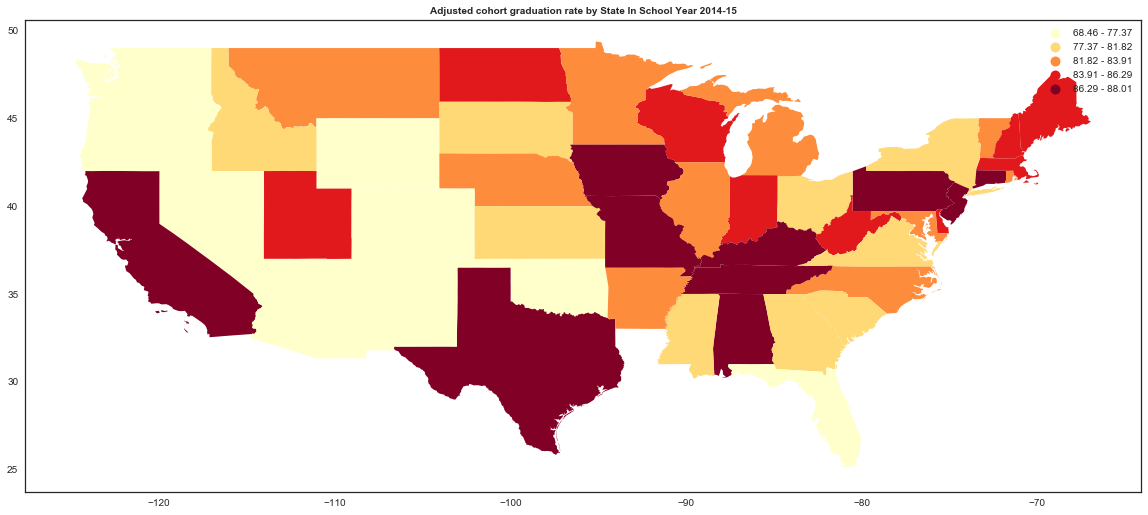


From the above heatmap it is very clear that the school district in Northeast and South region is doing better than the school district in Widwest and west region. Now check how 
these states are doing over time. 


In [15]:
import geopandas as gpd

acgrBySt2013 = round(acgr2013.groupby(['FIPCD'], as_index=False)['ALLA', 'ALLG'].sum(),2)
acgrBySt2013 = acgrBySt2013.sort_values('ALLA', ascending=False)
acgrBySt2013['ALLP'] = round(acgrBySt2013['ALLG']*100/acgrBySt2013['ALLA'],2)

acgrBySt2014 = round(acgr2014.groupby(['FIPCD'], as_index=False)['ALLA', 'ALLG'].sum(),2)
acgrBySt2014 = acgrBySt2014.sort_values('ALLA', ascending=False)
acgrBySt2014['ALLP'] = round(acgrBySt2014['ALLG']*100/acgrBySt2014['ALLA'],2)

sf = gpd.GeoDataFrame.from_file("data/states_21basic/states.shp")

sf['STATE_FIPS'] = pd.to_numeric(sf['STATE_FIPS'])
sf.rename(index=str, columns={"STATE_FIPS": "FIPCD"}, inplace=True)

response_map = pd.merge(sf,acgrBySt2014,on='FIPCD')
response_map = response_map[response_map['STATE_NAME'] != 'Hawaii']
response_map = response_map[response_map['STATE_NAME'] != 'Alaska']

ax = response_map.plot(column='ALLP', scheme='quantiles', k=5, cmap='YlOrRd', legend=True, figsize=(20,10));
ax.set_title('Adjusted cohort graduation rate by State In School Year 2014-15', fontsize = 10, fontweight = 'bold');
plt.show()

print(color.BOLD + '\nFrom the above heatmap it is very clear that the school district in Northeast and South region is doing better than the school district in Widwest and west region. Now check how \nthese states are doing over time.', color.BOLD)

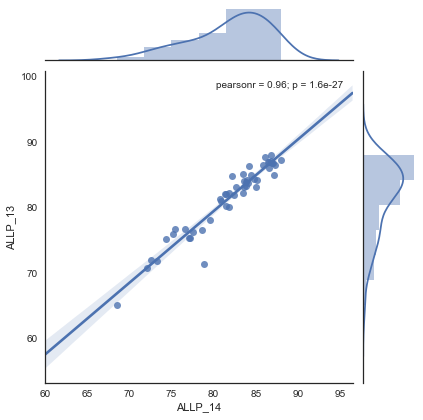


The above scatter plot, X-axis is showing the % of students graduated for each state in 
2014 and the Y-axis is showing the % of students graduated for each state in 2013. 
From this diagram this is clear that most of states are doing consistenyly well except few states.


In [16]:
acgrBySt2013 = round(acgr2013.groupby(['FIPCD'], as_index=False)['ALLA', 'ALLG'].sum(),2)
acgrBySt2013 = acgrBySt2013.sort_values('ALLA', ascending=False)
acgrBySt2013['ALLP'] = round(acgrBySt2013['ALLG']*100/acgrBySt2013['ALLA'],2)

acgrBySt2014 = round(acgr2014.groupby(['FIPCD'], as_index=False)['ALLA', 'ALLG'].sum(),2)
acgrBySt2014 = acgrBySt2014.sort_values('ALLA', ascending=False)
acgrBySt2014['ALLP'] = round(acgrBySt2014['ALLG']*100/acgrBySt2014['ALLA'],2)

dfcomb1 = pd.merge(acgrBySt2013, acgrBySt2014, how='inner', on= ['FIPCD'], left_index=False, right_index=False, sort=True, 
         suffixes=('_13', '_14'))
dfcomb2 = dfcomb1[['ALLP_13','ALLP_14']]

sns.jointplot(x="ALLP_14", y="ALLP_13", data=dfcomb2, kind="reg");

plt.show()

print(color.BOLD + '\nThe above scatter plot, X-axis is showing the % of students graduated for each state in \n2014 and the Y-axis is showing the % of students graduated for each state in 2013.', color.BOLD)
print(color.BOLD + 'From this diagram this is clear that most of states are doing consistenyly well except few states.' + color.BOLD)


Let us draw a comparison between all states and find out which states doing shaowing 
positive growth in % of students graduated.


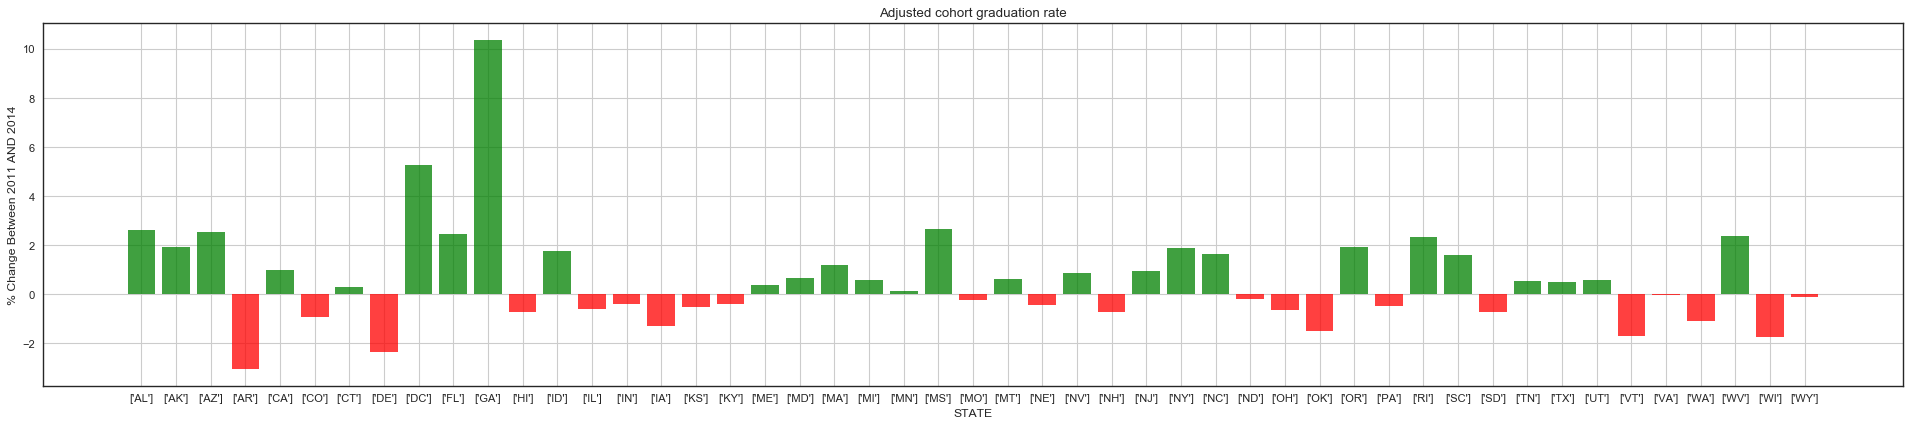

From the above histogram it is clear that most states shown positive growth in cohort 
graduation rate. 
But ARKANSAS,COLORADO,DELAWARE,HAWAII,ILLINOIS,INDIANA,IOWA,KANSAS,KENTUCKY,MISSOURI,NEBRASKA,NEW HAMPSHIRE,NORTH DAKOTA,OHIO,OKLAHOMA,PENNSYLVANIA,SOUTH DAKOTA,VERMONT,VIRGINIA,WASHINGTON,WISCONSIN,WYOMING are the states showing negative growth in cohort graduation rate. 


In [17]:
print(color.BOLD + '\nLet us draw a comparison between all states and find out which states doing shaowing \npositive growth in % of students graduated.' + color.BOLD)

temp11 = acgrBySt2013[['FIPCD', 'ALLP']]
temp11 = temp11.groupby(['FIPCD'], as_index=False).mean()

temp14 = acgrBySt2014[['FIPCD', 'ALLP']]
temp14 = temp14.groupby(['FIPCD'], as_index=False).mean()

dfcomb = pd.merge(temp11, temp14, how='inner', on= ['FIPCD'], left_index=False, right_index=False, sort=True, 
         suffixes=('_13', '_14'))

dfcomb['Change'] = ((dfcomb['ALLP_14'] - dfcomb['ALLP_13']) / dfcomb['ALLP_13']) * 100
dfcomb['Index'] = dfcomb['FIPCD'].map(getStateCode)
dfcomb['positive'] = dfcomb['Change'] > 0
dfcomb['FIPCD'].map(getStateCode)
    
plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')

objects = dfcomb['Index']
y_pos = np.arange(len(objects))
performance = dfcomb['Change']
 
plt.bar(y_pos, performance, align='center', alpha=0.75, color=dfcomb.positive.map({True: 'g', False: 'r'}))
plt.xticks(y_pos, objects)
plt.xlabel('STATE')
plt.ylabel('% Change Between 2011 AND 2014')
plt.title('Adjusted cohort graduation rate')
plt.grid()

plt.show()

print(color.BOLD + 'From the above histogram it is clear that most states shown positive growth in cohort \ngraduation rate.', color.BOLD)

dfStWithNegGr = dfcomb[dfcomb['positive'] != True]['FIPCD'].map(getStateName)
dfStWithNegGr = dfStWithNegGr.to_string(index = False)
dfStWithNegGr = re.sub( '\n', ',', dfStWithNegGr ).strip()
dfStWithNegGr = re.sub( ',\s+', ',', dfStWithNegGr ).strip()
dfStWithNegGr = dfStWithNegGr.replace('[', '').replace(']', '')

print(color.BOLD + 'But %s are the states showing negative growth in cohort graduation rate.' 
      %(dfStWithNegGr), color.BOLD)

Now we will verify the relation between the graduation rate and the %% of major racial and ethnic groups in these states and try to find any pattern. 


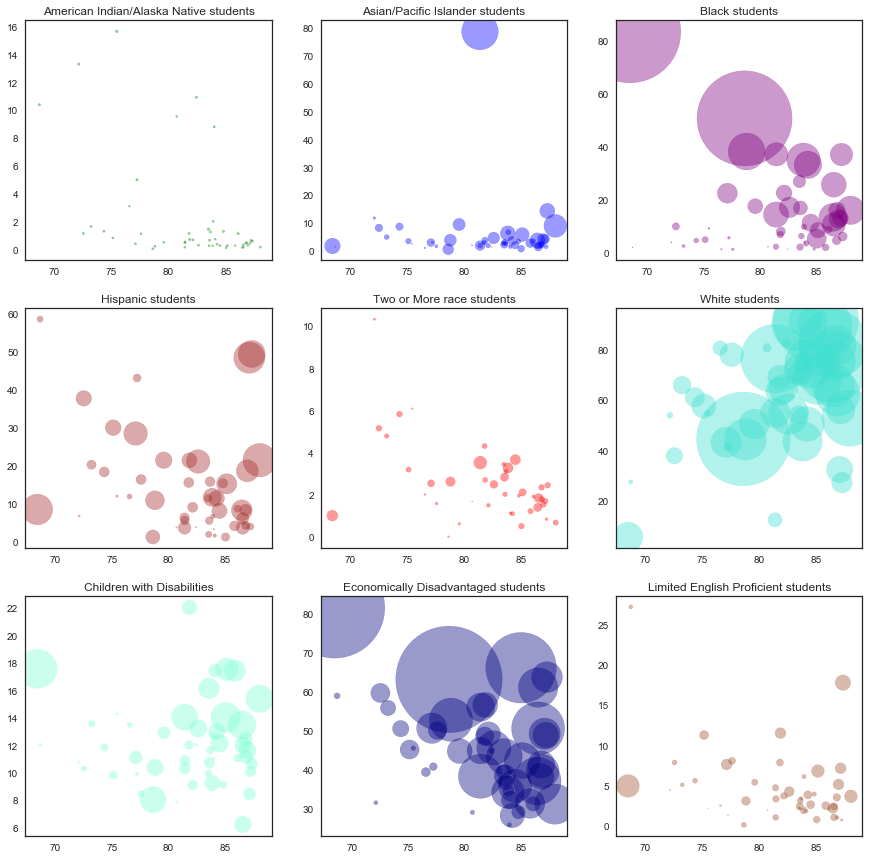

The above scatter plot is showing the % of students graduated in X-axis, % of students 
belong to a race in the Y-axis and the size of each bubble is representing the % of students graduated from the same race. 

From this diagram it is clear that % of American Indian/Alaska Native students and students with two or more has very less impact on the overall graduation rate. 


In [18]:
print(color.BOLD + 'Now we will verify the relation between the graduation rate and the %% of major racial and ethnic groups in these states and try to find any pattern.' , color.BOLD)

acgrBySt = round(acgr2014.groupby(['FIPCD'], as_index=False)[
    'ALLA', 'ALLG', 'MAMG', 'MAMA', 'MASG', 'MASA', 'MBLG', 'MBLA', 'MHIG', 'MHIA',
    'MWHG', 'MWHA', 'MTRG', 'MTRA', 'CWDG', 'CWDA', 'ECDG', 'ECDA', 'LEPG', 'LEPA'
    ].sum(),2)

acgrBySt = acgrBySt.sort_values('ALLA', ascending=False)
acgrBySt['ALLP'] = round(acgrBySt['ALLG']*100/acgrBySt['ALLA'],2)

acgrBySt['MAMP'] = round(acgrBySt['MAMG']*100/acgrBySt['MAMA'],2)
acgrBySt['MAMR'] = round(acgrBySt['MAMA']*100/acgrBySt['ALLA'],2)

acgrBySt['MASP'] = round(acgrBySt['MASG']*100/acgrBySt['MAMA'],2)
acgrBySt['MASR'] = round(acgrBySt['MASA']*100/acgrBySt['ALLA'],2)

acgrBySt['MBLP'] = round(acgrBySt['MBLG']*100/acgrBySt['MAMA'],2)
acgrBySt['MBLR'] = round(acgrBySt['MBLA']*100/acgrBySt['ALLA'],2)

acgrBySt['MHIP'] = round(acgrBySt['MHIG']*100/acgrBySt['MAMA'],2)
acgrBySt['MHIR'] = round(acgrBySt['MHIA']*100/acgrBySt['ALLA'],2)

acgrBySt['MWHP'] = round(acgrBySt['MWHG']*100/acgrBySt['MAMA'],2)
acgrBySt['MWHR'] = round(acgrBySt['MWHA']*100/acgrBySt['ALLA'],2)

acgrBySt['MTRP'] = round(acgrBySt['MTRG']*100/acgrBySt['MAMA'],2)
acgrBySt['MTRR'] = round(acgrBySt['MTRA']*100/acgrBySt['ALLA'],2)

acgrBySt['CWDP'] = round(acgrBySt['CWDG']*100/acgrBySt['MAMA'],2)
acgrBySt['CWDR'] = round(acgrBySt['CWDA']*100/acgrBySt['ALLA'],2)

acgrBySt['ECDP'] = round(acgrBySt['ECDG']*100/acgrBySt['MAMA'],2)
acgrBySt['ECDR'] = round(acgrBySt['ECDA']*100/acgrBySt['ALLA'],2)

acgrBySt['LEPP'] = round(acgrBySt['LEPG']*100/acgrBySt['MAMA'],2)
acgrBySt['LEPR'] = round(acgrBySt['LEPA']*100/acgrBySt['ALLA'],2)

acgrBySt = acgrBySt.fillna(0)

a = acgrBySt['ALLP']
b = acgrBySt['MAMR']
c = acgrBySt['MASR']
d = acgrBySt['MBLR']
e = acgrBySt['MHIR']
f = acgrBySt['MTRR']
g = acgrBySt['MWHR']
h = acgrBySt['CWDR']
i = acgrBySt['ECDR']
j = acgrBySt['LEPR']

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

area = acgrBySt['MAMP']/10
axes[0, 0].scatter(a, b, s=area, color='green', alpha=0.4)
axes[0, 0].set_title("American Indian/Alaska Native students")

area = acgrBySt['MASP']/10
axes[0, 1].scatter(a, c, s=area, color='blue', alpha=0.4)
axes[0, 1].set_title("Asian/Pacific Islander students")

area = acgrBySt['MBLP']/10
axes[0, 2].scatter(a, d, s=area, color='purple', alpha=0.4)
axes[0, 2].set_title("Black students");

area = acgrBySt['MHIP']/10
axes[1, 0].scatter(a, e, s=area, color='brown', alpha=0.4)
axes[1, 0].set_title("Hispanic students");

area = acgrBySt['MTRP']/10
axes[1, 1].scatter(a, f, s=area, color='red', alpha=0.4)
axes[1, 1].set_title("Two or More race students");

area = acgrBySt['MWHP']/10
axes[1, 2].scatter(a, g, s=area, color='Turquoise', alpha=0.4)
axes[1, 2].set_title("White students");

area = acgrBySt['CWDP']/10
axes[2, 0].scatter(a, h, s=area, color='Aquamarine', alpha=0.4)
axes[2, 0].set_title("Children with Disabilities");

area = acgrBySt['ECDP']/10
axes[2, 1].scatter(a, i, s=area, color='Navy', alpha=0.4)
axes[2, 1].set_title("Economically Disadvantaged students");

area = acgrBySt['LEPP']/10
axes[2, 2].scatter(a, j, s=area, color='Sienna', alpha=0.4)
axes[2, 2].set_title("Limited English Proficient students");

plt.show()

print(color.BOLD + 'The above scatter plot is showing the % of students graduated in X-axis, % of students \nbelong to a race in the Y-axis and the size of each bubble is representing the % of students graduated from the same race.' , color.BOLD)

print(color.BOLD + '\nFrom this diagram it is clear that % of American Indian/Alaska Native students and students with two or more has very less impact on the overall graduation rate.', color.BOLD)

In [19]:
#print(color.BOLD + '\nHence we are going to draw the heatmap of all these variables which may have an impact on overall graduation rate.', color.BOLD)

#acgr = acgr2014[['ALLP','MAMR','MASR','MBLR','MHIR','MWHR','MTRR','CWDR','ECDR','LEPR']]

#fig, ax = plt.subplots(figsize=(10, 8))
#corr = acgr.corr()
#sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
#            square=True, ax=ax)

#plt.show()

#print(color.BOLD + '\nHow the major racial and ethnic groups are co-related in 2014 are represented as follows\n\n %s.' %(corr.round(2)), color.BOLD)
#print(color.BOLD + '\nNow we are going to apply some machine learning technique to our dataset and see if we can predict a model.', color.BOLD)


Hence we are going to draw the heatmap of all these variables which may have an impact on overall graduation rate. 


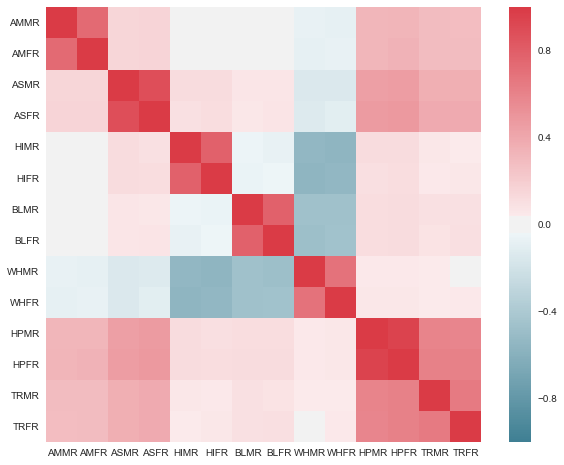


How the major racial and ethnic groups are co-related in 2014 are represented as follows

       AMMR  AMFR  ASMR  ASFR  HIMR  HIFR  BLMR  BLFR  WHMR  WHFR  HPMR  HPFR  \
AMMR  1.00  0.74  0.15  0.16 -0.00 -0.01 -0.01 -0.01 -0.07 -0.08  0.33  0.34   
AMFR  0.74  1.00  0.15  0.16 -0.01 -0.01 -0.01 -0.01 -0.08 -0.07  0.32  0.34   
ASMR  0.15  0.15  1.00  0.89  0.12  0.12  0.06  0.06 -0.15 -0.14  0.45  0.46   
ASFR  0.16  0.16  0.89  1.00  0.09  0.12  0.06  0.07 -0.13 -0.11  0.47  0.48   
HIMR -0.00 -0.01  0.12  0.09  1.00  0.78 -0.05 -0.07 -0.54 -0.56  0.12  0.12   
HIFR -0.01 -0.01  0.12  0.12  0.78  1.00 -0.06 -0.04 -0.56 -0.54  0.11  0.11   
BLMR -0.01 -0.01  0.06  0.06 -0.05 -0.06  1.00  0.79 -0.46 -0.47  0.12  0.12   
BLFR -0.01 -0.01  0.06  0.07 -0.07 -0.04  0.79  1.00 -0.48 -0.46  0.11  0.12   
WHMR -0.07 -0.08 -0.15 -0.13 -0.54 -0.56 -0.46 -0.48  1.00  0.69  0.05  0.05   
WHFR -0.08 -0.07 -0.14 -0.11 -0.56 -0.54 -0.47 -0.46  0.69  1.00  0.05  0.06   
HPMR  0.33  0.32  0.45  0.47

In [20]:
print(color.BOLD + '\nHence we are going to draw the heatmap of all these variables which may have an impact on overall graduation rate.', color.BOLD)

#acgr = acgr2014[['MASP','MBLP','MHIP','MWHP','CWDP','ECDP','LEPP','AMMR','AMFR','ASMR','ASFR','HIMR','HIFR','BLMR','BLFR','WHMR','WHFR','HPMR','HPFR','TRMR','TRFR']]
acgr = acgr2014[['AMMR','AMFR','ASMR','ASFR','HIMR','HIFR','BLMR','BLFR','WHMR','WHFR','HPMR','HPFR','TRMR','TRFR']]

fig, ax = plt.subplots(figsize=(10, 8))
corr = acgr.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

plt.show()

print('\nHow the major racial and ethnic groups are co-related in 2014 are represented as follows\n\n %s.' %(corr.round(2)))
print(color.BOLD + '\nNow we are going to apply some machine learning technique to our dataset and see if we can predict a model.', color.BOLD)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

#columns = ['MASP','MBLP','MHIP','MWHP','CWDP','ECDP','LEPP','AMMR','AMFR','ASMR','ASFR','HIMR','HIFR','BLMR','BLFR','WHMR','WHFR','HPMR','HPFR','TRMR']
columns = ['AMMR','AMFR','ASMR','ASFR','HIMR','HIFR','BLMR','BLFR','WHMR','WHFR','HPMR','HPFR','TRMR']

X = acgr2014[columns]
y = acgr2014['ALLP']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(pd.DataFrame(lm.coef_, index = X.columns, columns = ['estimatedCoefficients']))
print('MSE for training response data: {:.2f}'.format(np.mean((lm.predict(X_train) - y_train) **2)))
print('MSE for test response data: {:.2f}'.format(np.mean((lm.predict(X_test) - y_test) ** 2)))
print(model.score(X_test, y_test))

#plt.scatter(y_test, y_pred)
#plt.xlabel("True Values")
#plt.ylabel("Predictions")
#plt.show()

#plt.scatter(lm.predict(X_train), lm.predict(X_train) - y_train, c='b', s=40, alpha=0.5)
#plt.scatter(lm.predict(X_test), lm.predict(X_test) - y_test, c='g', s=40)
#plt.hlines(y = 0, xmin=-75, xmax = 110)
#plt.title('Residual Plot using training (blue) and test (green) data')
#plt.ylabel('Residuals')

#plt.show()

      estimatedCoefficients
AMMR              -0.119345
AMFR              -0.138144
ASMR              -0.123970
ASFR               1.190572
HIMR              -0.400087
HIFR               0.340986
BLMR              -0.228603
BLFR               0.297754
WHMR               0.141677
WHFR               0.367755
HPMR              -0.320054
HPFR               0.300750
TRMR              -1.340931
MSE for training response data: 451.15
MSE for test response data: 475.18
0.176150657556


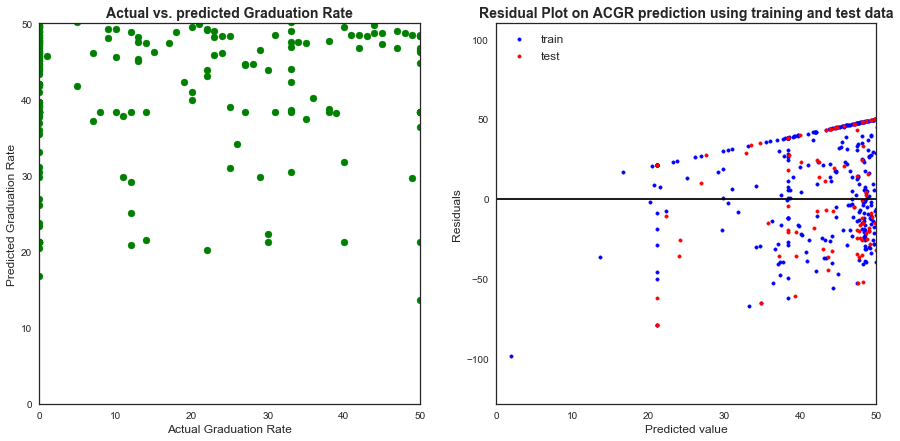

In [22]:
fig = plt.figure(figsize=(15, 7))

#Plot actual vs. predicted on response time
plt.subplot(1,2,1)
plt.scatter(y_train, lm.predict(X_train), c='g');
plt.xlim([0,50]);
plt.ylim([0,50]);
plt.xlabel('Actual Graduation Rate', fontsize = 12);
plt.ylabel('Predicted Graduation Rate', fontsize = 12);
plt.title('Actual vs. predicted Graduation Rate', fontsize = 14, fontweight = 'bold');

#Plot residuals of response time prediction
plt.subplot(1,2,2)
plt.scatter(lm.predict(X_train), lm.predict(X_train) - y_train, c='b', marker = '.', label = 'train')
plt.scatter(lm.predict(X_test), lm.predict(X_test) - y_test, c='r', marker = '.', label = 'test')
plt.hlines(y = 0, xmin=-50, xmax = 50)
plt.title('Residual Plot on ACGR prediction using training and test data',  fontsize = 14, fontweight = 'bold');
plt.ylabel('Residuals', fontsize = 12);
plt.xlabel('Predicted value', fontsize = 12);
plt.xlim([0,50]);
plt.legend(fontsize = 12, loc = 2)

In [23]:
#Using K-folds and cross-validation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(5, shuffle = True)
lm_acgr_cv = LinearRegression(normalize = True)

#Find MSE on response time prediction
scores = cross_val_score(lm_acgr_cv, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {:.2f} \nSE: {:.2f}'.format(np.mean(np.abs(scores)), scores.std()))

MSE: 453.98 
SE: 10.62


## Random forest regression

Training R2 on AGCR Random Forest prediction 0.8297394120569896


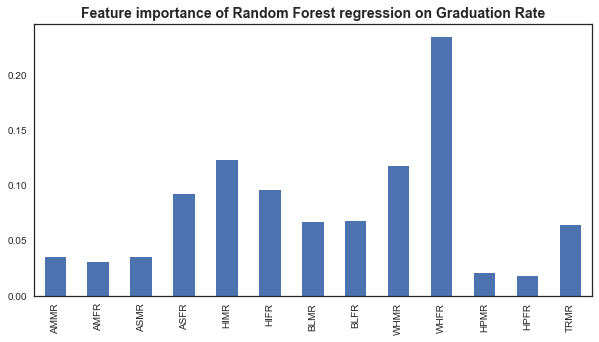

In [24]:
from sklearn.ensemble import RandomForestRegressor

rf_agrc = RandomForestRegressor(random_state = 10)

rf_agrc.fit(X_train, y_train)

agrc_score = rf_agrc.score(X_train, y_train)

print('Training R2 on AGCR Random Forest prediction {}'.format(agrc_score))

agrc_features = pd.Series(rf_agrc.feature_importances_, index = X.columns)
fig = plt.figure(figsize=(10,5));
agrc_features.plot(kind = 'bar');
plt.title('Feature importance of Random Forest regression on Graduation Rate', fontsize = 14, fontweight = 'bold');

In [25]:
#Find MSE on Graduation Rate prediction using 5 K-folds
kf = KFold(5, shuffle = True)
scores = cross_val_score(rf_agrc, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {} \nSE: {}'.format(np.mean(np.abs(scores)), scores.std()))

MSE: 396.7544000132564 
SE: 27.96704235939044


In [26]:
print('MSE for training response data: {:.2f}'.format(np.mean((rf_agrc.predict(X_train) - y_train) **2)))
print('MSE for test response data: {:.2f}'.format(np.mean((rf_agrc.predict(X_test) - y_test) ** 2)))

MSE for training response data: 97.18
MSE for test response data: 405.21


## Gradient Boosting Classifier

MSE: 372.4945
R2: 0.3614


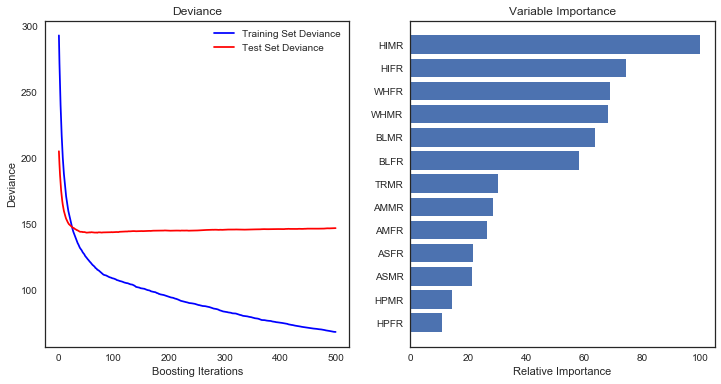

In [28]:
import random
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import GradientBoostingRegressor

#columns = ['MASP','MBLP','MHIP','MWHP','CWDP','ECDP','LEPP','AMMR','AMFR','ASMR','ASFR','HIMR','HIFR','BLMR','BLFR','WHMR','WHFR','HPMR','HPFR','TRMR']
columns = ['AMMR','AMFR','ASMR','ASFR','HIMR','HIFR','BLMR','BLFR','WHMR','WHFR','HPMR','HPFR','TRMR']

#X = acgr2014[columns]
#Y = acgr2014['ALLP']

rows = random.sample(list(acgr2014.index), int(len(acgr2014)*.80))
X_train, y_train = X.iloc[rows],y.iloc[rows]
X_test,y_test  = X.drop(rows),y.drop(rows)

params = {'n_estimators': 500, 'max_depth': 6,
        'learning_rate': 0.1, 'loss': 'huber','alpha':0.95}
clf = GradientBoostingRegressor(**params).fit(X_train, y_train)

mse = mean_squared_error(y_test, clf.predict(X_test))
r2 = r2_score(y_test, clf.predict(X_test))

print("MSE: %.4f" % mse)
print("R2: %.4f" % r2)

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [29]:
#Find MSE on Graduation Rate prediction using 5 K-folds
kf = KFold(5, shuffle = True)
scores = cross_val_score(rf_agrc, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {} \nSE: {}'.format(np.mean(np.abs(scores)), scores.std()))

MSE: 396.69606761850736 
SE: 11.167704872811964


In [30]:
print('MSE for training response data: {:.2f}'.format(np.mean((rf_agrc.predict(X_train) - y_train) **2)))
print('MSE for test response data: {:.2f}'.format(np.mean((rf_agrc.predict(X_test) - y_test) ** 2)))

MSE for training response data: 176.31
MSE for test response data: 165.69
